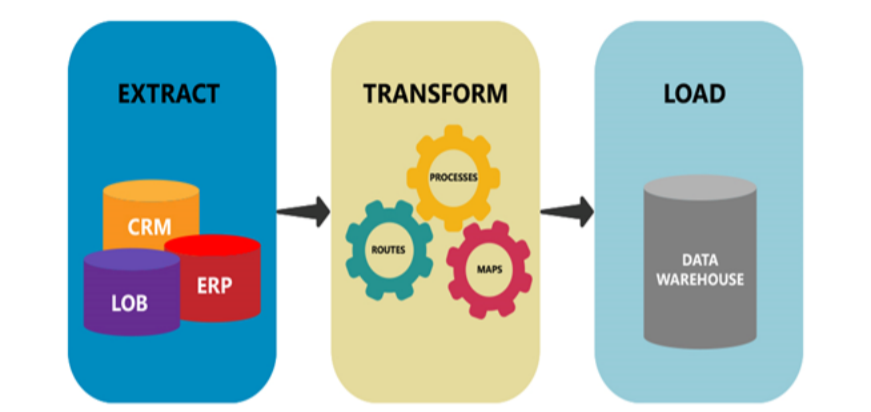

# **Extract Transform Load (ETL) Using Python**


## Objectives

*   Reading CSV and JSON file types.
*   Extracting data from the above file types.
*   Transforming data.
*   Ready-to-load format which we can use to load into DWH BigQuery


Import the required modules and functions


In [27]:
import glob                         # this module helps in selecting files
import pandas as pd                 # this module helps in processing CSV files
import xml.etree.ElementTree as ET  # this module helps in processing XML files.
from datetime import datetime

## Download Files


In [28]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0221EN-SkillsNetwork/labs/module%206/Lab%20-%20Extract%20Transform%20Load/data/datasource.zip

--2023-09-18 09:27:22--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0221EN-SkillsNetwork/labs/module%206/Lab%20-%20Extract%20Transform%20Load/data/datasource.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4249 (4.1K) [application/zip]
Saving to: ‘datasource.zip.1’

datasource.zip.1    100%[===================>]   4.15K  --.-KB/s    in 0s      

2023-09-18 09:27:23 (1.10 GB/s) - ‘datasource.zip.1’ saved [4249/4249]



## Unzip Files


In [29]:
!unzip datasource.zip -d dealership_data

Archive:  datasource.zip
replace dealership_data/used_car_prices1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## About the Data


The file `dealership_data` contains CSV, JSON, and XML files for used car data which contain features named `car_model`, `year_of_manufacture`, `price`, and `fuel`.


## Set Paths


In [30]:
tmpfile    = "dealership_temp.tmp"               # file used to store all extracted data
logfile    = "dealership_logfile.txt"            # all event logs will be stored in this file
targetfile = "dealership_transformed_data.csv"   # file where transformed data is stored

## Extract


### CSV Extract Function


In [31]:
def extract_from_csv(file_to_process):      #extract_from_csv name function to read_csv
    dataframe = pd.read_csv(file_to_process)
    return dataframe

### JSON Extract Function


In [32]:
def extract_from_json(file_to_process):
    dataframe = pd.read_json(file_to_process,lines=True)
    return dataframe

### XML Extract Function


In [33]:
def extract_from_xml(file_to_process):
    dataframe = pd.DataFrame(columns=['car_model','year_of_manufacture','price', 'fuel'])
    tree = ET.parse(file_to_process)
    root = tree.getroot()
    for person in root:
        car_model = person.find("car_model").text
        year_of_manufacture = int(person.find("year_of_manufacture").text)
        price = float(person.find("price").text)
        fuel = person.find("fuel").text
        dataframe = dataframe.append({"car_model":car_model, "year_of_manufacture":year_of_manufacture, "price":price, "fuel":fuel}, ignore_index=True)
    return dataframe

### Extract Function


In [34]:
def extract():
    extracted_data = pd.DataFrame(columns=['car_model','year_of_manufacture','price', 'fuel']) # create an empty data frame to hold extracted data

    #process all csv files
    for csvfile in glob.glob("dealership_data/*.csv"):
        extracted_data = extracted_data.append(extract_from_csv(csvfile), ignore_index=True)

    #process all json files
    for jsonfile in glob.glob("dealership_data/*.json"):
        extracted_data = extracted_data.append(extract_from_json(jsonfile), ignore_index=True)

    #process all xml files
    for xmlfile in glob.glob("dealership_data/*.xml"):
        extracted_data = extracted_data.append(extract_from_xml(xmlfile), ignore_index=True)

    return extracted_data




## Transform


In [35]:
def transform(data):
        data['price'] = round(data.price, 2)
        return data

## Loading


In [36]:
def load(targetfile,data_to_load):
    data_to_load.to_csv(targetfile)

## check new data

In [37]:
new_trans=pd.read_csv('/content/dealership_transformed_data.csv')
new_trans

,Unnamed: 0,car_model,year_of_manufacture,price,fuel
0,0,alto k10,2016,4253.73,Petrol
1,1,ignis,2017,7313.43,Petrol
2,2,sx4,2011,6567.16,Petrol
3,3,alto k10,2014,3731.34,Petrol
4,4,wagon r,2013,4328.36,Petrol
...,...,...,...,...,...
85,85,camry,2006,3731.34,Petrol
86,86,land cruiser,2010,52238.81,Diesel
87,87,corolla altis,2012,8805.97,Petrol
88,88,etios liva,2013,5149.25,Petrol


In [38]:
!pip install google-cloud-bigquery

In [39]:
from google.cloud import bigquery
from google.colab import auth
# Authenticate user account
auth.authenticate_user()

# Set up BigQuery client
client = bigquery.Client()

In [40]:
schema = [
    bigquery.SchemaField("car_model", "STRING"),
    bigquery.SchemaField("year_of_manufacture", "INTEGER"),
    bigquery.SchemaField("price", "FLOAT"),
    bigquery.SchemaField("fuel", "STRING")
]

In [41]:

# Read CSV data transformed into a pandas DataFrame
data = pd.read_csv('/content/dealership_transformed_data.csv')
data

,Unnamed: 0,car_model,year_of_manufacture,price,fuel
0,0,alto k10,2016,4253.73,Petrol
1,1,ignis,2017,7313.43,Petrol
2,2,sx4,2011,6567.16,Petrol
3,3,alto k10,2014,3731.34,Petrol
4,4,wagon r,2013,4328.36,Petrol
...,...,...,...,...,...
85,85,camry,2006,3731.34,Petrol
86,86,land cruiser,2010,52238.81,Diesel
87,87,corolla altis,2012,8805.97,Petrol
88,88,etios liva,2013,5149.25,Petrol


In [42]:
!pip install pandas-gbq

In [43]:
import pandas_gbq
project_id = 'dataanalytics-391911'
dataset_id = 'Car_Transform'
table_name = 'Car'

In [44]:
pandas_gbq.to_gbq(data, f'{"dataanalytics-391911"}.{"Car_Transform"}.{"Car"}', project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 5907.47it/s]
